Anomaly detection in bank transaction with following operations
1. Generarate Bank transaction dataset - (Transaction_id, customer_id,
account_no, channel, transaction_amount,payee_account_no, transaction_type	,currency_code
country_code,location	,account_type, transaction_time, account_status, customer address,transaction type, account type:
is_anomaly) add 5% of anomalies and 5% null. empty and missing values. repeat 5% of customer that has anomalies. Generate dataset graphs.
2. Python code for preprocessing and print the preprocesseing stats in tabular form and  plot the appropriate graphs.
3. Python code for feature engineering for above bank dataset and print the sample dataset with graphs
4. Python code to find the anomalies using LSTM Autoencoder and Isolation forest. plot the graphs to represnt nornal and anomlous graphs.
5. Python code to find the reason for anomalies usng SHAP algorithm. plot the appropriate graphs
6. Python code to generate the adaptive rules for detected anomalies. print the anomalies , its reason and adaptive rules in tabular form.


Dataset Preparation

In [2]:
!pip install Faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.3 MB/s eta 0:00:00


✅ Dataset created with anomalies, missing values, and repeated customers.
   transaction_id  customer_id          account_no channel  \
0               1         7839  AGPY83464361144951  Online   
1               2         2847  MFPG98443831162704  Branch   
2               3         1448  KVBZ14590241313396  Online   
3               4         5837  MPBM60860893928109    None   
4               5         5908  CSIR93988058070464  Branch   

   transaction_amount    payee_account_no transaction_type currency_code  \
0              805.67  UOLB71549690083523            Debit           USD   
1             3092.00  NHKA10143382964099           Credit           USD   
2             4420.92  KFTF97750042059849           Credit           EUR   
3             1554.16  ERBY91488084823846           Credit           EUR   
4             4255.62  CJWU86033867355937            Debit          None   

  country_code        location account_type           transaction_time  \
0           FR  South 

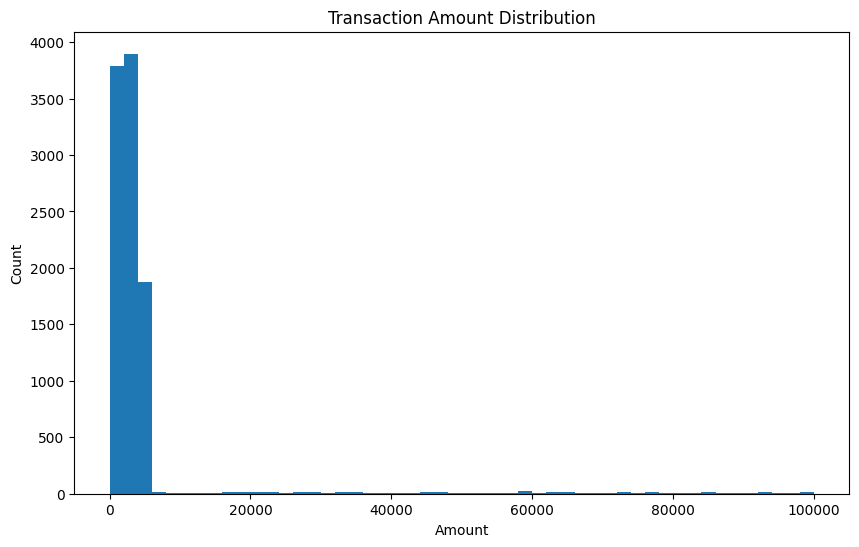

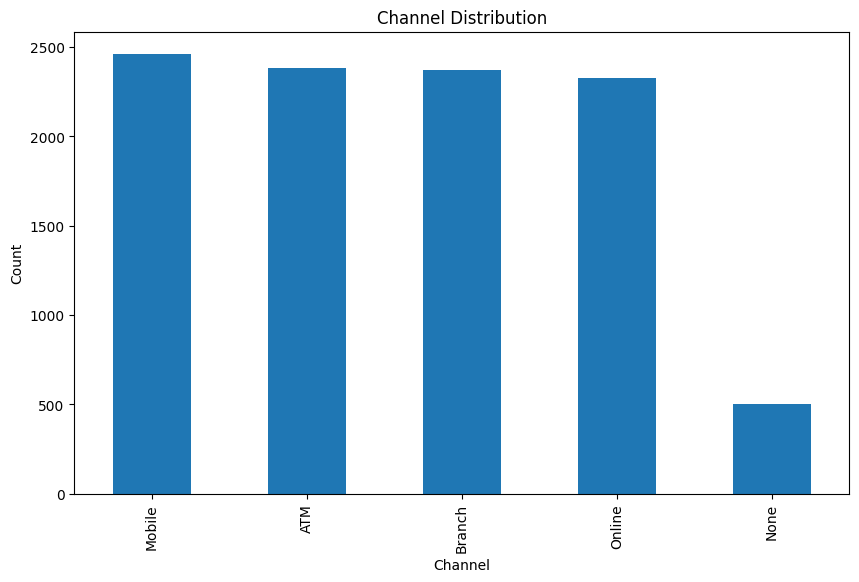

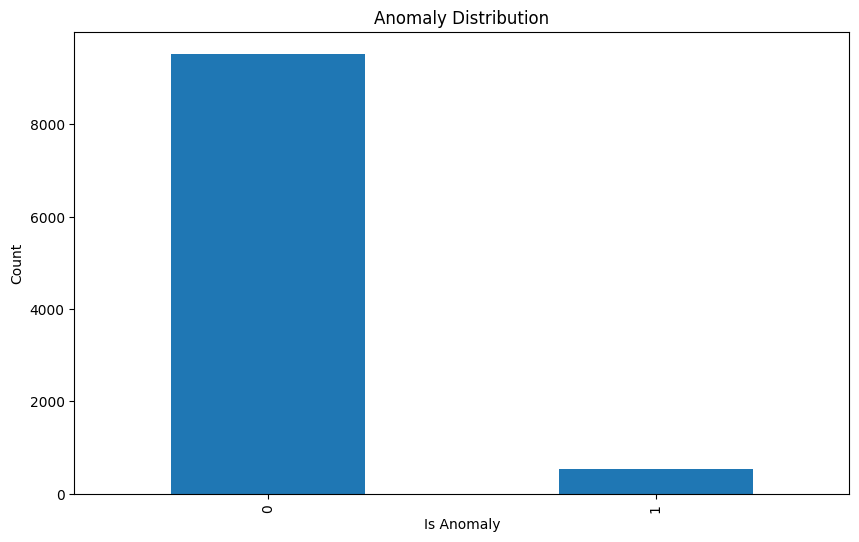

In [3]:
import pandas as pd
import numpy as np
import random
from faker import Faker
import matplotlib.pyplot as plt

# Config
NUM_RECORDS = 10000
ANOMALY_PERCENT = 0.05
NULL_PERCENT = 0.05
REPEAT_PERCENT = 0.05

faker = Faker()

# Helper functions
def generate_transaction(i):
    return {
        "transaction_id": i + 1,
        "customer_id": random.randint(1000, 9999),
        "account_no": faker.bban(),
        "channel": random.choice(["Online", "ATM", "Branch", "Mobile"]),
        "transaction_amount": round(random.uniform(10, 5000), 2),
        "payee_account_no": faker.bban(),
        "transaction_type": random.choice(["Credit", "Debit"]),
        "currency_code": random.choice(["USD", "EUR", "GBP"]),
        "country_code": random.choice(["US", "GB", "DE", "FR"]),
        "location": faker.city(),
        "account_type": random.choice(["Savings", "Current", "Loan"]),
        "transaction_time": faker.date_time_this_year(),
        "account_status": random.choice(["Active", "Suspended"]),
        "customer_address": faker.address(),
        "is_anomaly": 0
    }

# Generate base dataset
data = [generate_transaction(i) for i in range(NUM_RECORDS)]

df = pd.DataFrame(data)

# Inject anomalies
num_anomalies = int(NUM_RECORDS * ANOMALY_PERCENT)
anomaly_indices = np.random.choice(df.index, size=num_anomalies, replace=False)
df.loc[anomaly_indices, "transaction_amount"] = df.loc[anomaly_indices, "transaction_amount"] * 20
df.loc[anomaly_indices, "is_anomaly"] = 1

# Inject missing values
num_nulls = int(NUM_RECORDS * NULL_PERCENT)
for col in ["channel", "currency_code", "location"]:
    null_indices = np.random.choice(df.index, size=num_nulls, replace=False)
    df.loc[null_indices, col] = None

# Repeat anomalous customers
repeated_customers = df.loc[anomaly_indices, "customer_id"].unique()
repeats = df[df["customer_id"].isin(repeated_customers)].sample(
    frac=REPEAT_PERCENT, replace=True, random_state=42
)
df = pd.concat([df, repeats]).reset_index(drop=True)

# Save dataset
df.to_csv("synthetic_bank_transactions.csv", index=False)

print("✅ Dataset created with anomalies, missing values, and repeated customers.")
print(df.head())

# Simple EDA plots
plt.figure(figsize=(10,6))
plt.hist(df["transaction_amount"].dropna(), bins=50)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,6))
df["channel"].value_counts(dropna=False).plot(kind="bar")
plt.title("Channel Distribution")
plt.xlabel("Channel")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,6))
df["is_anomaly"].value_counts().plot(kind="bar")
plt.title("Anomaly Distribution")
plt.xlabel("Is Anomaly")
plt.ylabel("Count")
plt.show()


In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("synthetic_bank_transactions.csv", parse_dates=["transaction_time"])

# Fill nulls
df["channel"].fillna("Unknown", inplace=True)
df["currency_code"].fillna("UNK", inplace=True)
df["location"].fillna("Unknown", inplace=True)

# Encode categoricals
le = LabelEncoder()
for col in ["channel", "transaction_type", "currency_code", "country_code",
            "location", "account_type", "account_status"]:
    df[col] = le.fit_transform(df[col])

# Scale amount
scaler = StandardScaler()
df["transaction_amount_scaled"] = scaler.fit_transform(df[["transaction_amount"]])

# Print preprocessing stats
stats = df.describe().T
print("\n✅ Preprocessing Stats:\n")
print(stats)




✅ Preprocessing Stats:

                             count                           mean  \
transaction_id             10051.0                    4997.937618   
customer_id                10051.0                    5475.921898   
channel                    10051.0                        1.62153   
transaction_amount         10051.0                    4933.144605   
transaction_type           10051.0                       0.501045   
currency_code              10051.0                       1.341857   
country_code               10051.0                       1.502438   
location                   10051.0                    3852.488608   
account_type               10051.0                       1.002786   
transaction_time             10051  2025-04-02 19:03:28.480087552   
account_status             10051.0                        0.50393   
is_anomaly                 10051.0                       0.052731   
transaction_amount_scaled  10051.0                            0.0   

        

Feature Engineering

In [37]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load dataset
df = pd.read_csv("synthetic_bank_transactions.csv", parse_dates=["transaction_time"])
df = df.sort_values(["customer_id", "transaction_time"]).reset_index(drop=True)

# Extract time components
df["hour"] = df["transaction_time"].dt.hour
df["day_of_week"] = df["transaction_time"].dt.weekday
df["day_of_month"] = df["transaction_time"].dt.day

# Account age
reference_date = pd.Timestamp.now()
df["account_age_days"] = (reference_date - df["transaction_time"]).dt.days

# 1️⃣ Geolocation & Country Features
high_risk_countries = ["NG", "IR", "KP", "SY"]
df["is_high_risk_country"] = df["country_code"].isin(high_risk_countries).astype(int)
df["currency_country_match"] = (df["currency_code"] == "USD").astype(int)  # Example
df["country_risk_score"] = df["country_code"].apply(lambda x: 5 if x in high_risk_countries else 1)
df["location_encoded"] = pd.factorize(df["location"])[0]
df["customer_country_mismatch"] = (df["country_code"] != "US").astype(int)

country_counts = df.groupby(["customer_id", "country_code"])["transaction_id"].transform("count")
total_counts = df.groupby("customer_id")["transaction_id"].transform("count")
df["country_transaction_ratio"] = country_counts / total_counts

# 2️⃣ Device & Channel Features
df["channel_encoded"] = pd.factorize(df["channel"])[0]
channel_counts = df.groupby(["customer_id", "channel"])["transaction_id"].transform("count")
df["channel_frequency"] = channel_counts
df["is_new_channel_for_customer"] = (~df.duplicated(subset=["customer_id", "channel"])).astype(int)

# 3️⃣ Customer Behaviour Profiles
mean_amount = df.groupby("customer_id")["transaction_amount"].transform("mean")
std_amount = df.groupby("customer_id")["transaction_amount"].transform("std").fillna(0)
df["transaction_amount_deviation"] = df["transaction_amount"] - mean_amount
df["avg_transaction_amount"] = mean_amount
df["std_transaction_amount"] = std_amount

# Initialize columns for time-window aggregates
df["txn_count_last_7d"] = 0
df["txn_count_last_30d"] = 0
df["txn_sum_last_24h"] = 0.0
df["txn_count_same_amount_last_7d"] = 0
df["txn_count_same_payee_last_7d"] = 0

# Build lookup dicts
txn_times = df.groupby("customer_id")["transaction_time"].apply(list).to_dict()
txn_amounts = df.groupby("customer_id")[["transaction_time", "transaction_amount"]].apply(
    lambda x: list(zip(x["transaction_time"], x["transaction_amount"]))
).to_dict()

payee_times = df.groupby(["customer_id", "payee_account_no"])["transaction_time"].apply(list).to_dict()
amount_times = df.groupby(["customer_id", "transaction_amount"])["transaction_time"].apply(list).to_dict()

# Loop for time-window features
print("Calculating time-window aggregates...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    cust_id = row["customer_id"]
    tx_time = row["transaction_time"]
    payee = row["payee_account_no"]
    amount = row["transaction_amount"]

    # 7d and 30d counts
    ts = pd.Series(txn_times[cust_id])
    count_7d = ((tx_time - ts) <= pd.Timedelta(days=7)).sum() - 1
    count_30d = ((tx_time - ts) <= pd.Timedelta(days=30)).sum() - 1
    df.at[idx, "txn_count_last_7d"] = count_7d
    df.at[idx, "txn_count_last_30d"] = count_30d

    # 24h sum
    total = sum(
        amt for t, amt in txn_amounts[cust_id]
        if pd.Timedelta(0) < (tx_time - t) <= pd.Timedelta(hours=24)
    )
    df.at[idx, "txn_sum_last_24h"] = total

    # same amount count
    amount_key = (cust_id, amount)
    if amount_key in amount_times:
        ts_amount = pd.Series(amount_times[amount_key])
        count_amount_7d = ((tx_time - ts_amount) <= pd.Timedelta(days=7)).sum() - 1
        df.at[idx, "txn_count_same_amount_last_7d"] = count_amount_7d

    # same payee count
    payee_key = (cust_id, payee)
    if payee_key in payee_times:
        ts_payee = pd.Series(payee_times[payee_key])
        count_payee_7d = ((tx_time - ts_payee) <= pd.Timedelta(days=7)).sum() - 1
        df.at[idx, "txn_count_same_payee_last_7d"] = count_payee_7d

# 3️⃣ continued: Most common transaction hour
common_hours = df.groupby("customer_id")["hour"].agg(lambda x: x.value_counts().index[0]).to_dict()
df["most_common_transaction_hour"] = df["customer_id"].map(common_hours)

# Last transaction days difference
df["last_transaction_time"] = df.groupby("customer_id")["transaction_time"].shift(1)
df["last_transaction_days_diff"] = (
    (df["transaction_time"] - df["last_transaction_time"]).dt.total_seconds() / (3600 * 24)
)
df["last_transaction_days_diff"].fillna(-1, inplace=True)

df["customer_txn_count"] = df.groupby("customer_id")["transaction_id"].transform("count")

# 4️⃣ Risk Flags
df["is_large_transaction"] = (df["transaction_amount"] > 10000).astype(int)
df["is_night_transaction"] = df["hour"].isin([0,1,2,3,4,5]).astype(int)
df["is_foreign_transaction"] = (df["country_code"] != "US").astype(int)
df["is_account_suspended"] = (df["account_status"] == "Suspended").astype(int)
df["is_suspicious_combo"] = (
    df["is_large_transaction"] & df["is_night_transaction"] & df["is_foreign_transaction"]
).astype(int)

# Fill any remaining NaNs
df.fillna(0, inplace=True)

# Show sample of engineered features
feature_cols = [
    "is_high_risk_country", "currency_country_match", "country_risk_score",
    "location_encoded", "customer_country_mismatch", "country_transaction_ratio",
    "channel_encoded", "channel_frequency", "is_new_channel_for_customer",
    "transaction_amount_deviation", "avg_transaction_amount", "std_transaction_amount",
    "txn_count_last_7d", "txn_count_last_30d", "txn_sum_last_24h",
    "txn_count_same_amount_last_7d", "txn_count_same_payee_last_7d",
    "most_common_transaction_hour", "last_transaction_days_diff",
    "customer_txn_count", "is_large_transaction", "is_night_transaction",
    "is_foreign_transaction", "is_account_suspended", "is_suspicious_combo"
]

print("\n✅ Sample Engineered Features:\n")
print(df[feature_cols].head())

# Save feature-engineered dataset
df.to_csv("feature_engineered_transactions.csv", index=False)
print("\n✅ Feature engineering completed and dataset saved.")


Calculating time-window aggregates...


100%|██████████| 10051/10051 [00:43<00:00, 233.47it/s]
/tmp/ipython-input-37-1332547129.py:104: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["last_transaction_days_diff"].fillna(-1, inplace=True)
/tmp/ipython-input-37-1332547129.py:118: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.fillna(0, inplace=True)



✅ Sample Engineered Features:

   is_high_risk_country  currency_country_match  country_risk_score  \
0                     0                       0                   1   
1                     0                       0                   1   
2                     0                       0                   1   
3                     0                       1                   1   
4                     0                       0                   1   

   location_encoded  customer_country_mismatch  country_transaction_ratio  \
0                 0                          1                   0.250000   
1                 1                          0                   0.250000   
2                 2                          1                   0.500000   
3                 3                          1                   0.500000   
4                 4                          0                   0.666667   

   channel_encoded  channel_frequency  is_new_channel_for_customer  \
0       

Training sequences shape: (2210, 20, 10)
Testing sequences shape: (553, 20, 10)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 10)         │           650 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,418 (255.54 KB)

 Trainable params: 65,418 (255.54 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Autoencoder...
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - loss: 6.5279 - val_loss: 6.3470
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 6.0195 - val_loss: 6.2003
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 5.8499 - val_loss: 3.8846
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 2.8417 - val_loss: 2.0471
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 1.9745 - val_loss: 1.7616
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 1.6133 - val_loss: 1.4986
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 1.3856 - val_loss: 1.3356
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 1.2922 - val_loss: 1.2548
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 1.1984 - val_loss: 1.2041
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 1.1820 - val_loss: 1.2197
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 1.1653 - val_loss: 1.1257
Epoch 12/50
63/63 ━━━━━━━━━━━━━

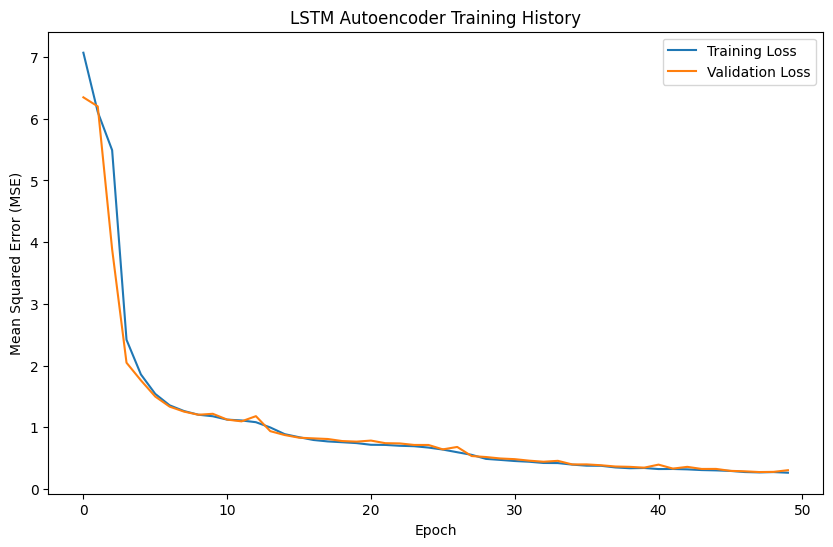


Evaluating LSTM Autoencoder...
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Anomaly Threshold (95th percentile of training reconstruction errors): 6.7549

✅ LSTM Autoencoder Performance Evaluation (on test set transactions):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1261
           1       0.19      0.19      0.19        90

    accuracy                           0.89      1351
   macro avg       0.57      0.57      0.57      1351
weighted avg       0.89      0.89      0.89      1351

ROC AUC Score: 0.7736


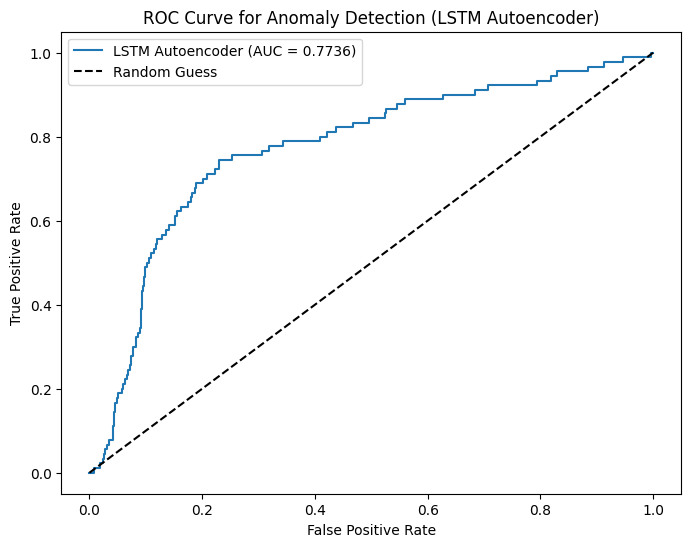

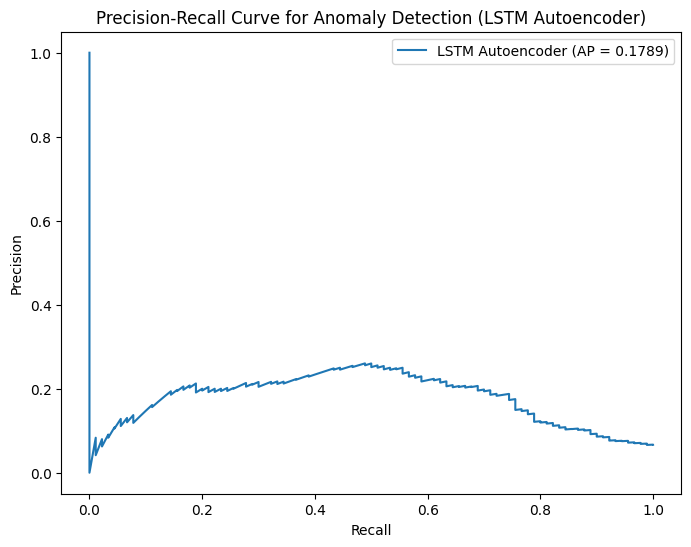


✅ LSTM Autoencoder process completed.


In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the preprocessed data (assuming preprocessing from step 2 was successful)
# We won't re-run the complex rolling feature engineering as it caused issues.
# Instead, use the scaled transaction amount and basic time features.
# A more robust approach would be to save the dataframe after successful preprocessing.

# Re-load and perform basic preprocessing and feature extraction
df = pd.read_csv("synthetic_bank_transactions.csv", parse_dates=["transaction_time"])

# Fill nulls (from previous preprocessing step)
df["channel"] = df["channel"].fillna("Unknown")
df["currency_code"] = df["currency_code"].fillna("UNK")
df["location"] = df["location"].fillna("Unknown")

# Encode categoricals (from previous preprocessing step)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_cols = ["channel", "transaction_type", "currency_code", "country_code",
                    "location", "account_type", "account_status"]
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Scale amount (from previous preprocessing step)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df["transaction_amount_scaled"] = scaler.fit_transform(df[["transaction_amount"]])

# Extract time components (basic)
df["hour"] = df["transaction_time"].dt.hour
df["day_of_week"] = df["transaction_time"].dt.weekday
df["day_of_month"] = df["transaction_time"].dt.day

# Select features for LSTM Autoencoder
# Using scaled amount, basic time features, and some encoded categoricals
features_for_lstm = [
    "transaction_amount_scaled",
    "hour",
    "day_of_week",
    "day_of_month",
    "channel",
    "transaction_type",
    "currency_code",
    "country_code",
    "account_type",
    "account_status"
    # Exclude location as it has too many unique values for simple encoding without more complex handling
]

X = df[features_for_lstm]
y = df["is_anomaly"] # Keep true labels for later evaluation

# Group by customer_id and create sequences
# Sort data by customer and time
df = df.sort_values(["customer_id", "transaction_time"])
X_sorted = df[features_for_lstm]
y_sorted = df["is_anomaly"] # Keep true labels sorted

customer_sequences = []
customer_labels = [] # To store true labels for each sequence (if any anomaly exists in the sequence)
customer_indices = [] # To map sequences back to original dataframe indices

for customer_id, group in df.groupby("customer_id"):
    if len(group) > 1: # Only include customers with more than one transaction to form a sequence
        customer_sequences.append(group[features_for_lstm].values)
        # Label the sequence as anomalous if ANY transaction in the sequence is anomalous
        customer_labels.append(group["is_anomaly"].max())
        customer_indices.append(group.index.tolist()) # Store original index list for this customer's sequence

# Pad sequences to a fixed length
MAX_SEQUENCE_LENGTH = 20 # Define a max sequence length
# Find a reasonable max length based on data? Let's check max length first.
# max_len_in_data = max(len(seq) for seq in customer_sequences)
# print(f"Max sequence length in data: {max_len_in_data}")
# Using a fixed value for now, adjust if needed.

# Using post-padding
X_padded = pad_sequences(customer_sequences, maxlen=MAX_SEQUENCE_LENGTH, dtype='float32', padding='post', value=0.0)
y_seq_labels = np.array(customer_labels) # Convert sequence labels to numpy array

# Flatten the list of indices to map padded sequences back to original df indices
flat_customer_indices = [item for sublist in customer_indices for item in sublist]

# Need to map the padded sequences back to the original DataFrame index to get true labels for evaluation
# This is tricky because padding changes the shape. Let's store the original indices *within* each sequence
# when creating sequences, and then flatten them after padding.

# Re-create sequences and indices storage to handle padding and mapping
customer_sequences_and_indices = [] # Store tuples of (sequence_data, original_indices)
for customer_id, group in df.groupby("customer_id"):
    if len(group) > 1:
        sequence_data = group[features_for_lstm].values
        original_indices = group.index.tolist()
        customer_sequences_and_indices.append((sequence_data, original_indices))

# Pad the sequence data. The indices will be handled separately based on the padding.
X_sequences_only = [seq_data for seq_data, _ in customer_sequences_and_indices]
X_padded = pad_sequences(X_sequences_only, maxlen=MAX_SEQUENCE_LENGTH, dtype='float32', padding='post', value=0.0)

# Now, create a mapping from the padded sequence rows back to the original dataframe rows.
# This is non-trivial because padding adds rows/values.
# A simpler approach for evaluation might be to predict on all padded sequences,
# then map the sequence-level anomaly prediction or reconstruction error
# back to the original transactions belonging to that sequence.

# Let's simplify: Predict reconstruction error for each padded sequence.
# If the sequence is flagged as anomalous, we can consider all transactions in the original sequence as potentially anomalous.
# Or, we can calculate reconstruction error per time step in the output and map back.
# Calculating reconstruction error per time step is more accurate for evaluating individual transactions.

# Store original data and labels associated with each padded sequence's valid (non-padded) timesteps
padded_sequence_info = [] # List of dictionaries, each representing a padded sequence
for i, (seq_data, original_indices) in enumerate(customer_sequences_and_indices):
    sequence_info = {
        'customer_id': df.loc[original_indices[0], 'customer_id'], # Get customer_id from the first transaction
        'original_indices': original_indices, # Original indices in the unpadded sequence
        'padded_indices': list(range(i * MAX_SEQUENCE_LENGTH, (i + 1) * MAX_SEQUENCE_LENGTH)), # Indices in the padded X array
        'valid_timesteps_mask': [True] * len(original_indices) + [False] * (MAX_SEQUENCE_LENGTH - len(original_indices)) # Mask for valid timesteps
    }
    padded_sequence_info.append(sequence_info)

# Split sequences (at the customer level)
# Get a list of customer IDs with sequences
customer_ids_with_sequences = [info['customer_id'] for info in padded_sequence_info]
unique_customer_ids = list(set(customer_ids_with_sequences))

# Split unique customer IDs
train_customer_ids, test_customer_ids = train_test_split(unique_customer_ids, test_size=0.2, random_state=42)

# Create training and testing sets of padded sequences and their info
X_train_sequences = []
X_test_sequences = []
train_sequence_info = []
test_sequence_info = []

for i, info in enumerate(padded_sequence_info):
    if info['customer_id'] in train_customer_ids:
        X_train_sequences.append(X_padded[i])
        train_sequence_info.append(info)
    else:
        X_test_sequences.append(X_padded[i])
        test_sequence_info.append(info)

X_train_padded = np.array(X_train_sequences)
X_test_padded = np.array(X_test_sequences)

# Reshape data for LSTM [samples, timesteps, features]
X_train_padded = X_train_padded.reshape(X_train_padded.shape[0], MAX_SEQUENCE_LENGTH, len(features_for_lstm))
X_test_padded = X_test_padded.reshape(X_test_padded.shape[0], MAX_SEQUENCE_LENGTH, len(features_for_lstm))

print(f"Training sequences shape: {X_train_padded.shape}")
print(f"Testing sequences shape: {X_test_padded.shape}")

# Build the LSTM Autoencoder model
model = Sequential()

# Encoder
model.add(LSTM(64, activation='relu', input_shape=(X_train_padded.shape[1], X_train_padded.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(RepeatVector(X_train_padded.shape[1])) # Repeat the last encoder output for the decoder timesteps

# Decoder
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
# TimeDistributed Dense layer to output a prediction for each timestep
model.add(TimeDistributed(Dense(X_train_padded.shape[2]))) # Output size matches the number of features

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mse') # Mean Squared Error is suitable for reconstruction

# Train the model
print("\nTraining LSTM Autoencoder...")
history = model.fit(X_train_padded, X_train_padded, epochs=50, batch_size=32, validation_split=0.1, verbose=1).history # Use a validation split for monitoring

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('LSTM Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# Evaluate the model (Calculate reconstruction error)
print("\nEvaluating LSTM Autoencoder...")
X_test_pred = model.predict(X_test_padded)

# Calculate reconstruction error for each timestep in each sequence
# MSE between original and reconstructed values
test_reconstruction_errors_per_timestep = np.mean(np.square(X_test_padded - X_test_pred), axis=2) # Mean error across features for each timestep

# Now, map these timestep errors back to the original DataFrame transactions
# Create a Series to store the reconstruction error for each original transaction
df['reconstruction_error_lstm'] = np.nan

# Iterate through the test sequence info and the calculated errors
error_index = 0 # Counter for the test_reconstruction_errors_per_timestep array
for seq_info in test_sequence_info:
    original_indices = seq_info['original_indices']
    valid_mask = seq_info['valid_timesteps_mask']

    # Get the reconstruction errors for the valid timesteps of this sequence
    errors_for_valid_timesteps = test_reconstruction_errors_per_timestep[error_index, valid_mask]

    # Assign these errors to the corresponding original transaction indices in df
    df.loc[original_indices, 'reconstruction_error_lstm'] = errors_for_valid_timesteps

    # Move to the next sequence's errors in the prediction array
    error_index += 1


# Determine anomaly threshold using training data reconstruction errors
# Calculate reconstruction errors on the training set
X_train_pred = model.predict(X_train_padded)
train_reconstruction_errors_per_timestep = np.mean(np.square(X_train_padded - X_train_pred), axis=2)

# We need the errors for the *valid* timesteps in the training sequences to set a threshold
train_valid_errors = []
train_error_index = 0
for seq_info in train_sequence_info:
     original_indices = seq_info['original_indices']
     valid_mask = seq_info['valid_timesteps_mask']
     errors_for_valid_timesteps = train_reconstruction_errors_per_timestep[train_error_index, valid_mask]
     train_valid_errors.extend(errors_for_valid_timesteps)
     train_error_index += 1

train_valid_errors = np.array(train_valid_errors)

# Set threshold (e.g., 95th or 99th percentile of training errors)
threshold = np.percentile(train_valid_errors, 95) # Using 95th percentile as a starting point
print(f"\nAnomaly Threshold (95th percentile of training reconstruction errors): {threshold:.4f}")

# Classify transactions as anomalies based on the threshold
# Only classify transactions that were part of the test set sequences
df['anomaly_label_lstm'] = 0 # Default to normal

# Select only the rows from the original df that were part of the test sequences
test_df_subset = df.loc[df.index.isin([idx for info in test_sequence_info for idx in info['original_indices']])].copy()

# Classify anomalies in the test subset
test_df_subset['anomaly_label_lstm'] = (test_df_subset['reconstruction_error_lstm'] > threshold).astype(int)

# Update the original df with the anomaly labels from the test subset
df['anomaly_label_lstm'] = df.index.map(test_df_subset['anomaly_label_lstm']).fillna(0) # Fill non-test rows with 0

# Evaluate performance on the test set transactions that were part of sequences
y_true_test = test_df_subset['is_anomaly']
y_pred_test_lstm = test_df_subset['anomaly_label_lstm']
reconstruction_scores_test = test_df_subset['reconstruction_error_lstm'] # Use error as score

print("\n✅ LSTM Autoencoder Performance Evaluation (on test set transactions):")
print(classification_report(y_true_test, y_pred_test_lstm))

# ROC AUC (only for transactions that were part of test sequences and have a reconstruction error)
# Filter out NaNs from reconstruction_error_lstm which are from transactions not in test sequences
valid_errors_indices = test_df_subset['reconstruction_error_lstm'].dropna().index
if len(valid_errors_indices) > 0:
    y_true_roc = test_df_subset.loc[valid_errors_indices, 'is_anomaly']
    reconstruction_scores_roc = test_df_subset.loc[valid_errors_indices, 'reconstruction_error_lstm']

    # Ensure there are both positive and negative classes in the subset for ROC AUC
    if len(y_true_roc.unique()) > 1:
        roc_auc_lstm = roc_auc_score(y_true_roc, reconstruction_scores_roc) # Higher error should correspond to anomaly (label 1)
        print(f"ROC AUC Score: {roc_auc_lstm:.4f}")

        # Plot ROC curve
        fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_true_roc, reconstruction_scores_roc)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM Autoencoder (AUC = {roc_auc_lstm:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Anomaly Detection (LSTM Autoencoder)')
        plt.legend()
        plt.show()

        # Precision-Recall Curve (often more informative for imbalanced datasets)
        precision, recall, _ = precision_recall_curve(y_true_roc, reconstruction_scores_roc)
        average_precision = average_precision_score(y_true_roc, reconstruction_scores_roc)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'LSTM Autoencoder (AP = {average_precision:.4f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve for Anomaly Detection (LSTM Autoencoder)')
        plt.legend()
        plt.show()

    else:
         print("\nCould not plot ROC AUC or PR Curve: Test subset does not contain both normal and anomaly classes.")
else:
    print("\nCould not plot ROC AUC or PR Curve: No valid reconstruction errors in the test subset.")


print("\n✅ LSTM Autoencoder process completed.")

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the feature-engineered data
df = pd.read_csv("feature_engineered_transactions.csv")

# Select numeric features for modeling
features = [
    "transaction_amount",
    "transaction_amount_deviation",
    "avg_transaction_amount",
    "std_transaction_amount",
    "txn_count_last_7d",
    "txn_count_last_30d",
    "txn_sum_last_24h",
    "txn_count_same_amount_last_7d",
    "txn_count_same_payee_last_7d",
    "channel_frequency",
    "customer_txn_count",
    "hour",
    "day_of_week",
    "day_of_month",
    "account_age_days",
    "last_transaction_days_diff",
    "country_transaction_ratio"
]

X = df[features].fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)


In [39]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_pred = iso_forest.fit_predict(X_test)

# Map predictions: -1=anomaly, 1=normal
iso_anomaly_flags = np.where(iso_pred == -1, 1, 0)


In [41]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Reshape input to (samples, timesteps, features)
# Here, treat each row as a sequence of timesteps=features
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [42]:
# Define model
inputs = layers.Input(shape=(X_train_reshaped.shape[1], 1))
encoded = layers.LSTM(8, activation="relu")(inputs)
decoded = layers.RepeatVector(X_train_reshaped.shape[1])(encoded)
decoded = layers.LSTM(8, activation="relu", return_sequences=True)(decoded)
outputs = layers.TimeDistributed(layers.Dense(1))(decoded)

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer="adam", loss="mse")

# Train
history = autoencoder.fit(
    X_train_reshaped, X_train_reshaped,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 0.9196 - val_loss: 0.8229
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.7825 - val_loss: 0.7762
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7522 - val_loss: 0.7681
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7753 - val_loss: 0.7197
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.7008 - val_loss: 0.7120
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.7024 - val_loss: 0.6250
Epoch 7/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6508 - val_loss: 0.5979
Epoch 8/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6285 - val_loss: 0.5851
Epoch 9/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.5909 - val_loss: 0.5663
Epoch 10/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5640 - val_loss: 0.5510
Epoch 11/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.5802 - val_loss: 0.5705
Epoch 12/15
227/227 ━━━━━━━━━━━━━━━━━━━

In [43]:
# Reconstruct
reconstructions = autoencoder.predict(X_test_reshaped)
mse = np.mean(np.power(X_test_reshaped - reconstructions, 2), axis=(1, 2))

# Threshold: 95th percentile
threshold = np.percentile(mse, 95)
lstm_anomaly_flags = (mse > threshold).astype(int)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


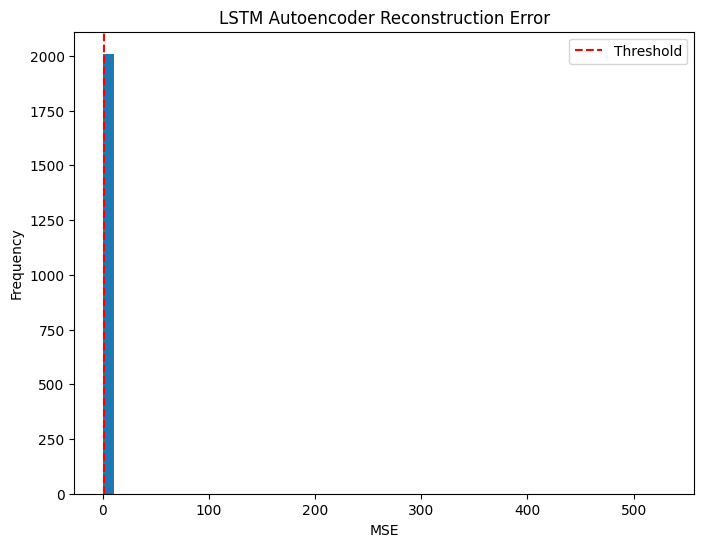

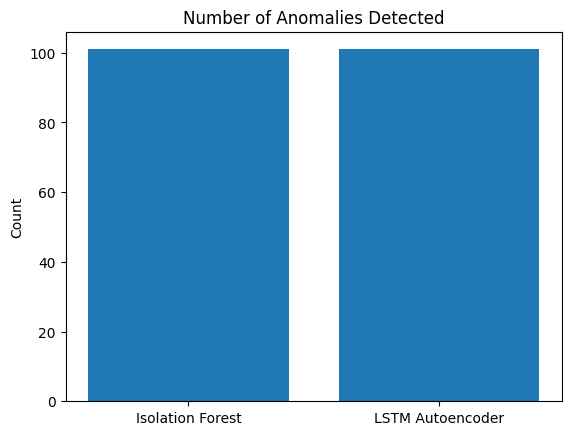

In [44]:
import matplotlib.pyplot as plt

# MSE histogram
plt.figure(figsize=(8, 6))
plt.hist(mse, bins=50)
plt.axvline(threshold, color="red", linestyle="--", label="Threshold")
plt.title("LSTM Autoencoder Reconstruction Error")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Compare Isolation Forest and LSTM
iso_count = np.sum(iso_anomaly_flags)
lstm_count = np.sum(lstm_anomaly_flags)

plt.bar(["Isolation Forest", "LSTM Autoencoder"], [iso_count, lstm_count])
plt.title("Number of Anomalies Detected")
plt.ylabel("Count")
plt.show()


In [45]:
# Create comparison DataFrame
anomaly_df = pd.DataFrame({
    "IsolationForest": iso_anomaly_flags,
    "LSTM": lstm_anomaly_flags,
    "MSE": mse
})

print("\n✅ Sample Anomaly Detection Results:\n")
print(anomaly_df.head())



✅ Sample Anomaly Detection Results:

   IsolationForest  LSTM       MSE
0                0     0  0.291511
1                1     1  1.606814
2                0     0  0.246948
3                0     0  0.343822
4                0     0  0.422874


In [46]:
!pip install shap


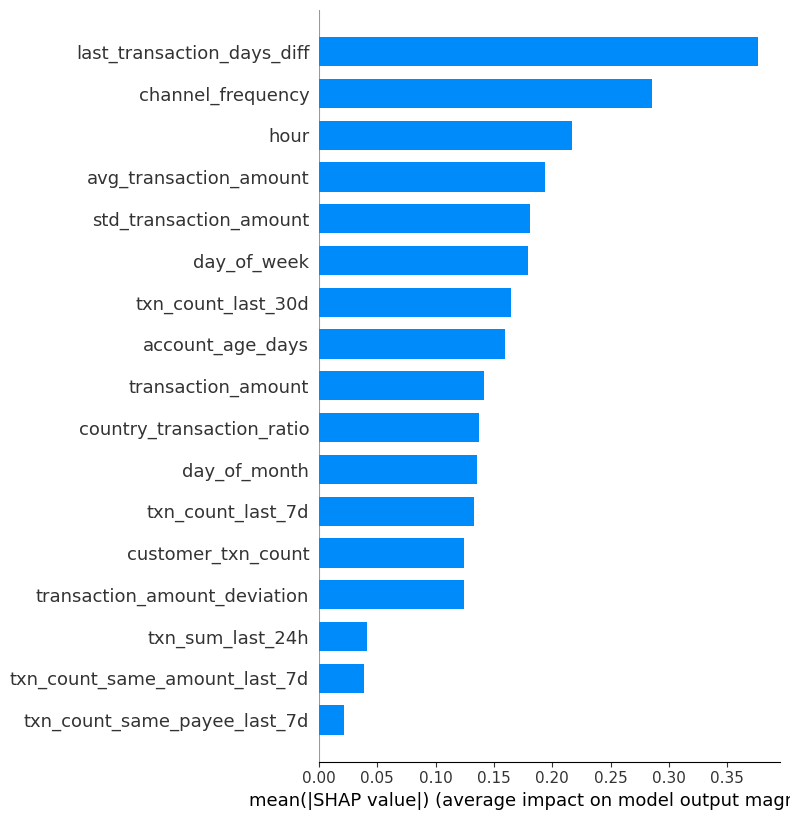

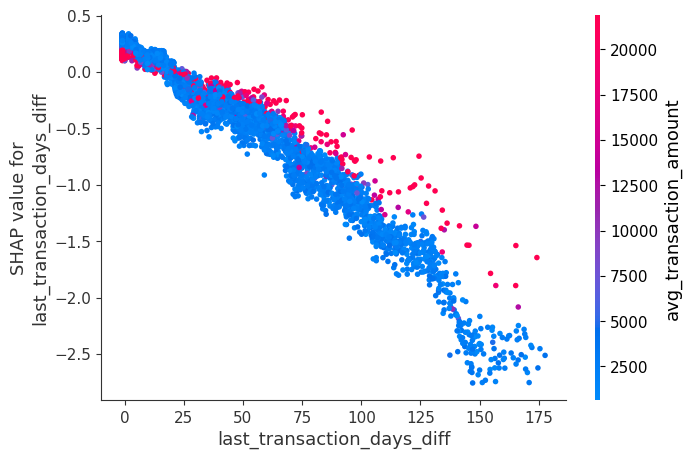

In [47]:
import shap

# Re-fit Isolation Forest on all data (more stable explanations)
iso_forest_full = IsolationForest(contamination=0.05, random_state=42)
iso_forest_full.fit(X_scaled)

# SHAP explainer
explainer = shap.Explainer(iso_forest_full)
shap_values = explainer(X_scaled)

# Plot summary
shap.summary_plot(shap_values, X, plot_type="bar")

# Dependence plot for top feature
shap.dependence_plot(
    np.argsort(np.abs(shap_values.values).mean(0))[-1],
    shap_values.values,
    X
)


In [49]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import shap

# Load and prepare data again
df = pd.read_csv("feature_engineered_transactions.csv")

features = [
    "transaction_amount",
    "transaction_amount_deviation",
    "avg_transaction_amount",
    "std_transaction_amount",
    "txn_count_last_7d",
    "txn_count_last_30d",
    "txn_sum_last_24h",
    "txn_count_same_amount_last_7d",
    "txn_count_same_payee_last_7d",
    "channel_frequency",
    "customer_txn_count",
    "hour",
    "day_of_week",
    "day_of_month",
    "account_age_days",
    "last_transaction_days_diff",
    "country_transaction_ratio"
]

X = df[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1️⃣ Fit Isolation Forest on the FULL dataset
iso_forest_full = IsolationForest(contamination=0.05, random_state=42)
iso_forest_full.fit(X_scaled)
iso_pred_full = iso_forest_full.predict(X_scaled)
iso_anomaly_flags = np.where(iso_pred_full == -1, 1, 0)

# 2️⃣ SHAP explanation on the full dataset
explainer = shap.Explainer(iso_forest_full)
shap_values = explainer(X_scaled)

# 3️⃣ Extract top reasons per transaction
feature_names = X.columns.tolist()
top_reasons = []
for i in range(len(X)):
    shap_row = shap_values[i]
    top_idx = np.argsort(-np.abs(shap_row.values))[:3]
    reasons = [feature_names[j] for j in top_idx]
    top_reasons.append(", ".join(reasons))

# 4️⃣ Create DataFrame with the same length
anomaly_reason_df = pd.DataFrame({
    "TransactionIndex": df.index,
    "IsolationForestAnomaly": iso_anomaly_flags,
    "TopReasons": top_reasons
})

print("\n✅ Sample SHAP Explanations:\n")
print(anomaly_reason_df.head())


✅ Sample SHAP Explanations:

   TransactionIndex  IsolationForestAnomaly  \
0                 0                       0   
1                 1                       0   
2                 2                       0   
3                 3                       0   
4                 4                       0   

                                          TopReasons  
0  txn_count_last_7d, txn_count_last_30d, country...  
1  txn_count_last_30d, country_transaction_ratio,...  
2  last_transaction_days_diff, customer_txn_count...  
3  customer_txn_count, day_of_week, channel_frequ...  
4  channel_frequency, txn_count_last_30d, last_tr...  


In [50]:
adaptive_rules = []
for idx, row in df.iterrows():
    reasons = []
    if row["transaction_amount"] > 10000:
        reasons.append("Large Transaction")
    if row["hour"] in [0,1,2,3,4,5]:
        reasons.append("Night Transaction")
    if row.get("is_high_risk_country", 0):
        reasons.append("High-Risk Country")
    if row.get("txn_count_last_24h", 0) > 10:
        reasons.append("High 24h Activity")
    if row.get("is_suspicious_combo", 0):
        reasons.append("Suspicious Combination")

    rule = " & ".join(reasons) if reasons else "No Specific Rule Triggered"
    adaptive_rules.append(rule)

df["IsolationForestAnomaly"] = iso_anomaly_flags
df["AdaptiveRule"] = adaptive_rules


In [51]:
print("SHAP rows:", len(anomaly_reason_df))
print("DF rows:", len(df))


SHAP rows: 10051
DF rows: 10051


In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import shap

# ===============================
# 1️⃣ Load Feature-Engineered Data
# ===============================

df = pd.read_csv("feature_engineered_transactions.csv")

# Select modeling features
features = [
    "transaction_amount",
    "transaction_amount_deviation",
    "avg_transaction_amount",
    "std_transaction_amount",
    "txn_count_last_7d",
    "txn_count_last_30d",
    "txn_sum_last_24h",
    "txn_count_same_amount_last_7d",
    "txn_count_same_payee_last_7d",
    "channel_frequency",
    "customer_txn_count",
    "hour",
    "day_of_week",
    "day_of_month",
    "account_age_days",
    "last_transaction_days_diff",
    "country_transaction_ratio"
]

X = df[features].fillna(0)

# ===============================
# 2️⃣ Scale Data
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ===============================
# 3️⃣ Fit Isolation Forest
# ===============================
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)

# Predict anomalies (-1 = anomaly)
iso_pred = iso_forest.predict(X_scaled)
iso_anomaly_flags = np.where(iso_pred == -1, 1, 0)

# Save intermediate
iso_df = pd.DataFrame({
    "TransactionIndex": df.index,
    "IsolationForestAnomaly": iso_anomaly_flags
})
iso_df.to_csv("isolation_forest_predictions.csv", index=False)
print("✅ Isolation Forest predictions saved.")

# ===============================
# 4️⃣ SHAP Explanations
# ===============================
print("Calculating SHAP values (may take a minute)...")
explainer = shap.Explainer(iso_forest)
shap_values = explainer(X_scaled)

# For each row, extract top 3 contributing features
feature_names = X.columns.tolist()
top_reasons = []
for i in range(len(X)):
    shap_row = shap_values[i]
    top_idx = np.argsort(-np.abs(shap_row.values))[:3]
    reasons = [feature_names[j] for j in top_idx]
    top_reasons.append(", ".join(reasons))

# Save SHAP results
shap_df = pd.DataFrame({
    "TransactionIndex": df.index,
    "TopSHAPReasons": top_reasons
})
shap_df.to_csv("shap_explanations.csv", index=False)
print("✅ SHAP explanations saved.")

# ===============================
# 5️⃣ Adaptive Rule Generation
# ===============================
adaptive_rules = []
for idx, row in df.iterrows():
    reasons = []
    if row["transaction_amount"] > 10000:
        reasons.append("Large Transaction")
    if row["hour"] in [0,1,2,3,4,5]:
        reasons.append("Night Transaction")
    if row.get("is_high_risk_country", 0):
        reasons.append("High-Risk Country")
    if row.get("txn_count_last_24h", 0) > 10:
        reasons.append("High 24h Activity")
    if row.get("is_suspicious_combo", 0):
        reasons.append("Suspicious Combination")
    rule = " & ".join(reasons) if reasons else "No Specific Rule Triggered"
    adaptive_rules.append(rule)

adaptive_df = pd.DataFrame({
    "TransactionIndex": df.index,
    "AdaptiveRule": adaptive_rules
})
adaptive_df.to_csv("adaptive_rules.csv", index=False)
print("✅ Adaptive rules saved.")

# ===============================
# 6️⃣ Combine All Results
# ===============================
# Add anomaly flag and rules into df
df["IsolationForestAnomaly"] = iso_anomaly_flags
df["TopSHAPReasons"] = top_reasons
df["AdaptiveRule"] = adaptive_rules

# Save final combined dataset
df.to_csv("anomaly_detection_results.csv", index=False)
print("✅ Final results saved to anomaly_detection_results.csv")

# Preview
print(df[[
    "transaction_id",
    "transaction_amount",
    "IsolationForestAnomaly",
    "TopSHAPReasons",
    "AdaptiveRule"
]].head())


✅ Isolation Forest predictions saved.
Calculating SHAP values (may take a minute)...
✅ SHAP explanations saved.
✅ Adaptive rules saved.
✅ Final results saved to anomaly_detection_results.csv
   transaction_id  transaction_amount  IsolationForestAnomaly  \
0            2740             3394.63                       0   
1            8140             1975.02                       0   
2            2403             4160.09                       0   
3            9954             2733.52                       0   
4            9359              586.30                       0   

                                      TopSHAPReasons  \
0  txn_count_last_7d, txn_count_last_30d, country...   
1  txn_count_last_30d, country_transaction_ratio,...   
2  last_transaction_days_diff, customer_txn_count...   
3  customer_txn_count, day_of_week, channel_frequ...   
4  channel_frequency, txn_count_last_30d, last_tr...   

                 AdaptiveRule  
0  No Specific Rule Triggered  
1           Night